## Обучение RNN модели на моделирование любой характеристики ситстемы

##### в финальной версии моделируются одновременно все параметры системы, высоко кореллирующие с целевой переменной
##### команда: /talkiiing

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import pandas as pd
train_df = pd.read_csv("train_df.csv")

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
train_df.head(20)

,len,day,month,hour,minute,count_city_x0_Алматы,count_city_x0_Анталья,count_city_x0_Варадеро,count_city_x0_Владивосток,count_city_x0_Волгоград,...,check_terminal_percentile_75,sum_arrive_to_event,std_arrive_to_event,mean_arrive_to_event,tst_percentile_25,tst_percentile_75,tst_day,tst_month,tst_hour,tst_minute
0,16,1,7,0,0.0,0.0,2.0,0.0,4.0,0.0,...,0.00,158785.537,7205.349019,9924.096062,5683.98400,8962.30450,1,7,0,0.0
1,29,1,7,0,1.0,0.0,4.0,0.0,8.0,0.0,...,1.00,410100.456,15262.568520,14141.395034,5596.82300,9796.65000,1,7,0,1.0
2,16,1,7,0,2.0,0.0,3.0,0.0,0.0,0.0,...,1.00,211245.303,12980.451377,13202.831437,5479.58800,13958.37675,1,7,0,2.0
3,21,1,7,0,3.0,0.0,5.0,0.0,0.0,0.0,...,1.00,212390.117,10541.459757,10113.815095,5501.18000,8771.49000,1,7,0,3.0
4,18,1,7,0,4.0,0.0,5.0,0.0,2.0,0.0,...,1.00,240504.436,15743.664759,13361.357555,5152.21200,8123.99775,1,7,0,4.0
5,19,1,7,0,5.0,0.0,2.0,0.0,8.0,1.0,...,0.50,157037.257,7562.723722,8265.118789,5366.71000,8385.41500,1,7,0,5.0
6,22,1,7,0,6.0,0.0,2.0,0.0,6.0,0.0,...,0.75,291703.427,13656.034993,13259.246681,5324.75500,9298.56200,1,7,0,6.0
7,18,1,7,0,7.0,0.0,3.0,0.0,4.0,1.0,...,1.00,143429.982,5877.090058,7968.332333,5265.38575,8404.67825,1,7,0,7.0
8,15,1,7,0,8.0,0.0,2.0,0.0,2.0,3.0,...,1.00,211206.037,11179.484720,14080.402466,6240.23000,26652.53350,1,7,0,8.0
9,15,1,7,0,9.0,0.0,8.0,0.0,0.0,1.0,...,1.00,142242.599,7327.079112,9482.839933,6172.65000,9315.63000,1,7,0,9.0


In [6]:
columns_to_use = ["len", "day", "hour", "minute"] + list(train_df.columns[-40:])

In [9]:
xs = []
ys = []
count_last_samples = 100
for i in range(0, len(train_df) - count_last_samples, count_last_samples//6):
    x = train_df.iloc[i:i+count_last_samples]
    y = train_df.iloc[i+count_last_samples].len

    xs.append(x[columns_to_use])
    ys.append(y)

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(xs, ys, test_size=0.2)

In [119]:
import random

class SequenceDataset:
    def __init__(self, sequences, labels):
        # self.sequences = [i[0].transpose(1, 0) for i in dataset]
        self.sequences = sequences
        self.labels = labels

    def __getitem__(self, idx: int) -> List[int]:
        sequence = self.sequences[idx].fillna(0).values
        label = self.labels[idx]

        train_sample = {
            "text": sequence,
            "label": label
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.sequences)

In [120]:
def collate_fn_with_padding(input_batch: List[List[int]], max_len = 600, pad_value=[0]) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][-max_seq_len:]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_value)
        new_batch.append(sequence['text'])

    sequences = torch.FloatTensor(new_batch).to(device)
    labels = torch.FloatTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [121]:
len(x_train)

709

In [122]:
train_dataset = SequenceDataset(x_train, y_train)

np.random.seed(42)
eval_dataset = SequenceDataset(x_valid, y_valid)

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [123]:
next(iter(train_dataloader))["input_ids"].shape
# next(iter(train_dataloader))["label"]

torch.Size([64, 600, 44])

## Архитектура модели

In [124]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.to(device) for t in (h0, c0)]

In [125]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

def evaluate(model, dataloader):
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits)
            target.append(batch['label'])

    predictions = torch.cat(predictions).cpu().detach().numpy()
    target = torch.cat(target).cpu()

    mape = mean_absolute_percentage_error(target, predictions)
    mae = mean_absolute_error(target, predictions)

    return mape, mae

In [126]:
from statistics import mean
num_epoch = 3
eval_steps = len(train_dataloader) // 2

losses = []

hist_train_accs = []
hist_eval_accs = []

hist_train_f1 = []
hist_eval_f1 = []

mean_value_answer = []

model = LSTMClassifier(input_dim=24, hidden_dim=64, layer_dim=3, output_dim=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [127]:
model

LSTMClassifier(
  (rnn): LSTM(24, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [128]:
count_last_samples

600

In [129]:
next(iter(train_dataloader))["input_ids"].shape

torch.Size([64, 600, 44])

## Обучение модели

In [ ]:

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).squeeze(dim=1)
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    model.eval()
    train_acc, train_f1 = evaluate(model, train_dataloader)
    test_acc, test_f1 = evaluate(model, eval_dataloader)
    model.train()

    hist_eval_f1.append(test_f1)
    hist_train_f1.append(train_f1)

    hist_eval_accs.append(test_acc)
    hist_train_accs.append(train_acc)

    print(f"cur mae: {test_f1};    cur mape: {test_acc}")

    losses.append(sum(epoch_losses) / len(epoch_losses))

In [131]:
sample, y = x_train[0], y_train[0]

In [132]:
sample

,len,day,hour,minute,count_city_x0_Сочи,count_city_x0_Стамбул,count_city_x0_Уфа,count_city_x0_Хабаровск,count_city_x0_Челябинск,count_city_x0_Шанхай,...,check_terminal_percentile_75,sum_arrive_to_event,std_arrive_to_event,mean_arrive_to_event,tst_percentile_25,tst_percentile_75,tst_day,tst_month,tst_hour,tst_minute
73000,34,20,17,39.0,2.0,0.0,0.0,0.0,1.0,8.0,...,1.0,288289.699,5552.713857,8479.108794,4383.74850,9048.37725,20,8,17,39.0
73001,40,20,17,40.0,4.0,0.0,0.0,0.0,0.0,2.0,...,1.0,321956.788,4651.600112,8048.919700,5285.09800,8966.32900,20,8,17,40.0
73002,32,20,17,41.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,276018.668,5853.576197,8625.583375,3827.43200,13393.78550,20,8,17,41.0
73003,35,20,17,42.0,2.0,0.0,0.0,0.0,0.0,2.0,...,1.0,313818.236,6986.528909,8966.235314,5103.85200,8683.37350,20,8,17,42.0
73004,36,20,17,43.0,2.0,0.0,0.0,0.0,0.0,2.0,...,1.0,273223.205,5452.525381,7589.533472,4885.30400,8791.82500,20,8,17,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73595,16,21,3,34.0,2.0,0.0,1.0,0.0,0.0,0.0,...,1.0,359542.541,14413.887349,22471.408812,13233.08725,26672.98150,21,8,3,34.0
73596,16,21,3,35.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,290740.521,13072.360560,18171.282562,13152.69900,15995.98775,21,8,3,35.0
73597,16,21,3,36.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,286821.842,15253.724422,17926.365125,8029.35725,16931.01775,21,8,3,36.0
73598,14,21,3,37.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,338680.810,19526.011827,24191.486428,13035.54325,32784.06850,21,8,3,37.0


## Немного визуализации

In [133]:
import matplotlib.pyplot as plt

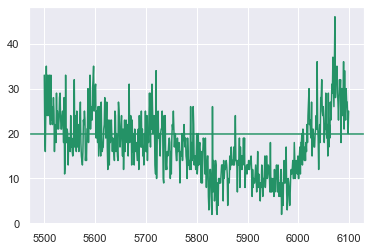

In [134]:
num = 6
sample, y = x_train[num], y_train[num]

plt.plot(sample.len)
plt.axhline(y)

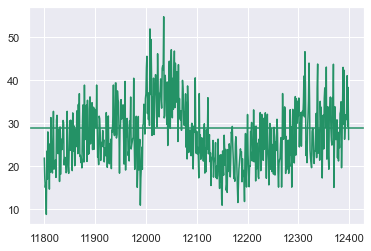

In [142]:
num = 2
sample, y = x_train[num], y_train[num]

plt.plot(sample.config_sum / 200)
plt.axhline(y)

In [15]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error


In [16]:
mean_absolute_percentage_error(y_valid, predicts)

0.2625926522868465